In [20]:
import os
from pathlib import Path
import cv2
import numpy as np
import kagglehub
import json
import matplotlib.pyplot as plt

path = kagglehub.dataset_download("trainingdatapro/cars-video-object-tracking")
print("Path to dataset files:", path)

DATASET_DIR = Path(path)

Path to dataset files: /Users/Marta/.cache/kagglehub/datasets/trainingdatapro/cars-video-object-tracking/versions/3


In [21]:
# Explore the dataset structure
print("Dataset contents:")
for item in DATASET_DIR.iterdir():
    print(f"  {item.name}")

Dataset contents:
  annotations.xml
  images
  boxes


In [22]:
# Look for annotation files (common formats: .json, .txt, .xml, .csv)
annotation_files = []
for ext in ['.json', '.txt', '.xml', '.csv']:
    annotation_files.extend(list(DATASET_DIR.rglob(f"*{ext}")))

print(f"Found {len(annotation_files)} annotation files:")
for f in annotation_files[:10]:  # Show first 10
    print(f"  {f.relative_to(DATASET_DIR)}")

Found 1 annotation files:
  annotations.xml


In [23]:
# Examine the XML structure
xml_file = DATASET_DIR / "annotations.xml"
if xml_file.exists():
    # Read first few lines to understand structure
    with open(xml_file, 'r') as f:
        lines = f.readlines()[:50]
    print("First 50 lines of annotations.xml:")
    print("".join(lines))
else:
    print("annotations.xml not found directly in DATASET_DIR")
    # Try to find it
    xml_files = list(DATASET_DIR.rglob("annotations.xml"))
    if xml_files:
        print(f"Found at: {xml_files[0]}")
        with open(xml_files[0], 'r') as f:
            lines = f.readlines()[:50]
        print("First 50 lines:")
        print("".join(lines))

First 50 lines of annotations.xml:
<?xml version="1.0" encoding="utf-8"?>
<annotations>
  <version>1.1</version>
  <meta>
    <task>
      <mode>interpolation</mode>
      <overlap>5</overlap>
      <start_frame>0</start_frame>
      <stop_frame>300</stop_frame>
      <segments>
        <segment>
          <start>0</start>
          <stop>300</stop>
        </segment>
      </segments>
      <owner>
        <username>Training Data</username>
      </owner>
      <labels>
        <label>
          <name>car</name>
          <color>#2a00ff</color>
          <type>rectangle</type>
          <attributes>
          </attributes>
        </label>
        <label>
          <name>minivan</name>
          <color>#b725ff</color>
          <type>rectangle</type>
          <attributes>
          </attributes>
        </label>
      </labels>
      <original_size>
        <width>1920</width>
        <height>1080</height>
      </original_size>
      <source>source.mp4</source>
    </task>
  </meta>

## Load and Parse Annotations

Once we identify the annotation format, we'll load them and extract bbox dimensions (width, height, area) along with their vertical position (y coordinate).

In [24]:
import xml.etree.ElementTree as ET

def load_annotations(xml_path):
    """
    Load annotations from XML file.
    Returns list of dicts with keys: x, y, w, h, y_bottom, area, frame_id
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    bbox_stats = []
    
    # Get image dimensions
    img_width = int(root.find('.//meta/task/original_size/width').text)
    img_height = int(root.find('.//meta/task/original_size/height').text)
    
    print(f"Image dimensions: {img_width} x {img_height}")
    
    # Parse all tracks
    for track in root.findall('track'):
        track_id = track.get('id')
        label = track.get('label')
        
        for box in track.findall('box'):
            frame = int(box.get('frame'))
            xtl = float(box.get('xtl'))
            ytl = float(box.get('ytl'))
            xbr = float(box.get('xbr'))
            ybr = float(box.get('ybr'))
            
            # Calculate bbox dimensions
            w = xbr - xtl
            h = ybr - ytl
            area = w * h
            
            bbox_stats.append({
                'frame': frame,
                'track_id': track_id,
                'label': label,
                'x': xtl,
                'y': ytl,
                'w': w,
                'h': h,
                'y_bottom': ybr,  # Bottom of bbox
                'area': area,
                'img_height': img_height
            })
    
    return bbox_stats, img_height

# Load annotations
xml_file = DATASET_DIR / "annotations.xml"
bbox_stats, IMG_HEIGHT = load_annotations(xml_file)

print(f"\nTotal bboxes: {len(bbox_stats)}")
print(f"Sample bbox: {bbox_stats[0]}")

Image dimensions: 1920 x 1080

Total bboxes: 9673
Sample bbox: {'frame': 27, 'track_id': '0', 'label': 'car', 'x': 592.83, 'y': 0.0, 'w': 25.149999999999977, 'h': 12.08, 'y_bottom': 12.08, 'area': 303.8119999999997, 'img_height': 1080}


## Analyze Bbox Size vs Vertical Position

We'll bin the bboxes by vertical position (top, middle, bottom) and compute statistics for each region.

In [25]:
# Analyze bbox size vs vertical position
bbox_data = np.array([(b['y_bottom'], b['area']) for b in bbox_stats])

# Divide into vertical bins
n_bins = 10
bins = np.linspace(0, IMG_HEIGHT, n_bins + 1)

print("Bbox area statistics by vertical position:\n")
for i in range(n_bins):
    y_min, y_max = bins[i], bins[i+1]
    mask = (bbox_data[:, 0] >= y_min) & (bbox_data[:, 0] < y_max)
    areas_in_bin = bbox_data[mask, 1]
    
    if len(areas_in_bin) > 0:
        print(f"Y range [{int(y_min):4d}, {int(y_max):4d}] ({len(areas_in_bin):4d} bboxes):")
        print(f"  Min area:    {areas_in_bin.min():8.0f} px²")
        print(f"  5th %ile:    {np.percentile(areas_in_bin, 5):8.0f} px²")
        print(f"  Median:      {np.median(areas_in_bin):8.0f} px²")
        print(f"  95th %ile:   {np.percentile(areas_in_bin, 95):8.0f} px²")
        print(f"  Max area:    {areas_in_bin.max():8.0f} px²")
        print()

Bbox area statistics by vertical position:

Y range [   0,  108] (1939 bboxes):
  Min area:         144 px²
  5th %ile:         388 px²
  Median:           947 px²
  95th %ile:       1494 px²
  Max area:        2472 px²

Y range [ 108,  216] (2787 bboxes):
  Min area:        1206 px²
  5th %ile:        1772 px²
  Median:          2276 px²
  95th %ile:       3492 px²
  Max area:        5417 px²

Y range [ 216,  324] (2132 bboxes):
  Min area:        2658 px²
  5th %ile:        3967 px²
  Median:          4605 px²
  95th %ile:       5213 px²
  Max area:       10125 px²

Y range [ 324,  432] ( 814 bboxes):
  Min area:        4865 px²
  5th %ile:        6822 px²
  Median:          7516 px²
  95th %ile:      10598 px²
  Max area:       17770 px²

Y range [ 432,  540] ( 775 bboxes):
  Min area:        9406 px²
  5th %ile:       10758 px²
  Median:         10758 px²
  95th %ile:      15495 px²
  Max area:       28092 px²

Y range [ 540,  648] ( 749 bboxes):
  Min area:       15298 px²
  5th %

In [ ]:
# Extract outlier bboxes (below min_area and above max_area for each bin)
outlier_bboxes = []
for i in range(n_bins):
    y_min, y_max = bins[i], bins[i+1]
    mask = (bbox_data[:, 0] >= y_min) & (bbox_data[:, 0] < y_max)
    areas_in_bin = bbox_data[mask, 1]
    y_in_bin = bbox_data[mask, 0]
    if len(areas_in_bin) > 0:
        minA = np.percentile(areas_in_bin, 5)
        maxA = np.percentile(areas_in_bin, 95)
        # Find outliers below minA and above maxA
        for y_val, area_val in zip(y_in_bin, areas_in_bin):
            if area_val < minA or area_val > maxA:
                outlier_bboxes.append({'y': y_val, 'area': area_val, 'bin': i})
print(f"Total outlier bboxes: {len(outlier_bboxes)}")
# Show a few outliers
for ob in outlier_bboxes[:10]:
    print(ob)

## Visualize Size Distribution

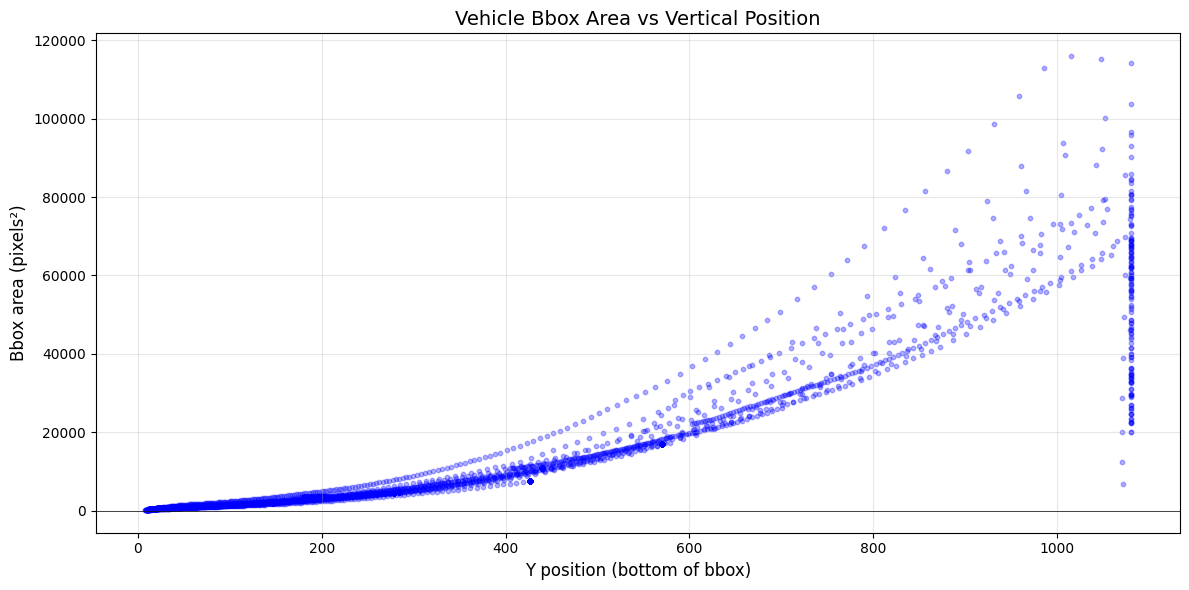

In [26]:
# Plot area vs vertical position
plt.figure(figsize=(12, 6))
plt.scatter(bbox_data[:, 0], bbox_data[:, 1], alpha=0.3, s=10, c='blue')
plt.xlabel('Y position (bottom of bbox)', fontsize=12)
plt.ylabel('Bbox area (pixels²)', fontsize=12)
plt.title('Vehicle Bbox Area vs Vertical Position', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.tight_layout()
plt.show()

## Fit Perspective Model

Based on the statistics, we'll create a function that returns min/max area bounds for any y position.

Fitted min_area function (constrained perspective model):
  min_area = 2000.00 + 44749.12*t²
  where t = y / 1080

Fitted max_area function (constrained perspective model):
  max_area = 2000.00 + 108157.55*t²
  where t = y / 1080


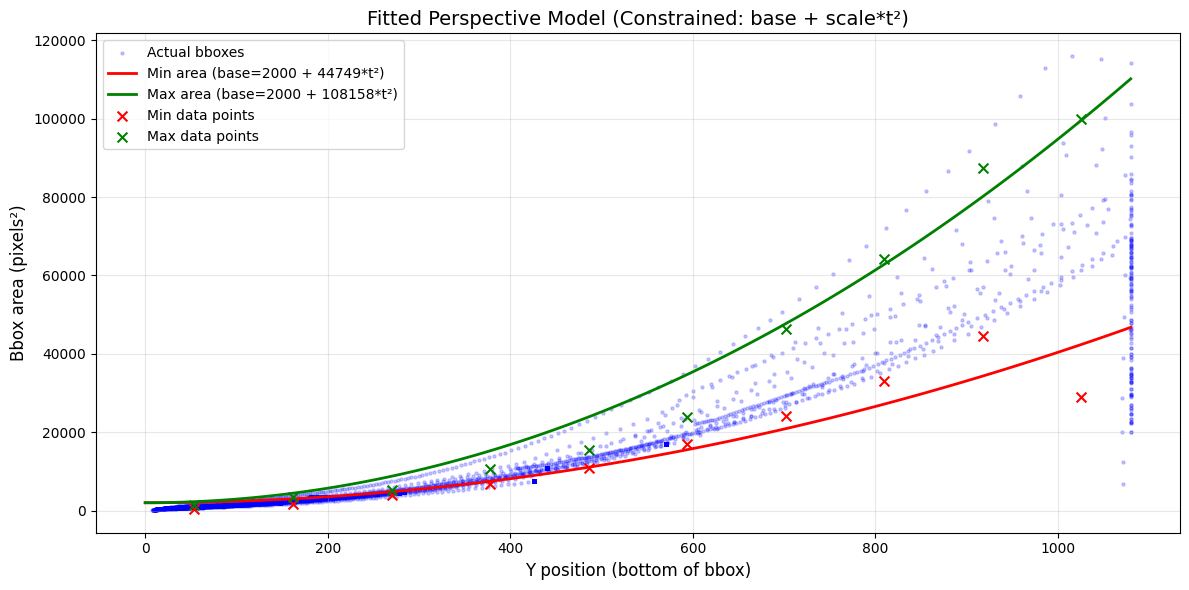

In [27]:
# Use ONLY quadratic term (no constant or linear) for clean perspective scaling
# This ensures: area scales as t² (perspective), always positive, starts from reasonable minimum

# Collect min/max areas for each bin
y_centers = (bins[:-1] + bins[1:]) / 2
min_areas = []
max_areas = []
y_values_with_data = []

for i in range(n_bins):
    y_min, y_max = bins[i], bins[i+1]
    mask = (bbox_data[:, 0] >= y_min) & (bbox_data[:, 0] < y_max)
    areas_in_bin = bbox_data[mask, 1]
    
    if len(areas_in_bin) > 5:
        min_areas.append(np.percentile(areas_in_bin, 5))   # 5th percentile for safety
        max_areas.append(np.percentile(areas_in_bin, 95))  # 95th percentile for safety
        y_values_with_data.append(y_centers[i])

# Simple model: area = base + scale * t²  (pure perspective scaling)
# This CANNOT go negative and follows physics of perspective
def perspective_model(y, base, scale):
    """Clean perspective model: base + scale*t² (always positive)"""
    t = y / IMG_HEIGHT
    return base + scale * t * t

from scipy.optimize import curve_fit

# Fit with constraints: base > 0, scale > 0
y_fit = np.array(y_values_with_data)
params_min, _ = curve_fit(perspective_model, y_fit, min_areas, p0=[500, 15000], bounds=([100, 1000], [2000, 50000]))
params_max, _ = curve_fit(perspective_model, y_fit, max_areas, p0=[5000, 100000], bounds=([2000, 10000], [200000, 200000]))

print("Fitted min_area function (constrained perspective model):")
print(f"  min_area = {params_min[0]:.2f} + {params_min[1]:.2f}*t²")
print(f"  where t = y / {IMG_HEIGHT}")
print()
print("Fitted max_area function (constrained perspective model):")
print(f"  max_area = {params_max[0]:.2f} + {params_max[1]:.2f}*t²")
print(f"  where t = y / {IMG_HEIGHT}")

# Plot the fitted curves
y_plot = np.linspace(0, IMG_HEIGHT, 100)
min_fit = perspective_model(y_plot, *params_min)
max_fit = perspective_model(y_plot, *params_max)

plt.figure(figsize=(12, 6))
plt.scatter(bbox_data[:, 0], bbox_data[:, 1], alpha=0.2, s=5, c='blue', label='Actual bboxes')
plt.plot(y_plot, min_fit, 'r-', linewidth=2, label=f'Min area (base={params_min[0]:.0f} + {params_min[1]:.0f}*t²)')
plt.plot(y_plot, max_fit, 'g-', linewidth=2, label=f'Max area (base={params_max[0]:.0f} + {params_max[1]:.0f}*t²)')
plt.scatter(y_values_with_data, min_areas, c='red', s=50, marker='x', label='Min data points', zorder=5)
plt.scatter(y_values_with_data, max_areas, c='green', s=50, marker='x', label='Max data points', zorder=5)
plt.xlabel('Y position (bottom of bbox)', fontsize=12)
plt.ylabel('Bbox area (pixels²)', fontsize=12)
plt.title('Fitted Perspective Model (Constrained: base + scale*t²)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Export Results

Save the fitted parameters to use in the main tracking notebook.

In [28]:
# Save results to use in tracking notebook
results = {
    'image_height': IMG_HEIGHT,
    'image_width': 1920,
    'min_area_params': {
        'base': float(params_min[0]),
        'scale': float(params_min[1])
    },
    'max_area_params': {
        'base': float(params_max[0]),
        'scale': float(params_max[1])
    },
    'formula': 'area = base + scale*t^2, where t = y/image_height'
}

output_file = 'bbox_size_model.json'
with open(output_file, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Saved bbox size model to {output_file}")
print("\nYou can now use these parameters in your tracking notebook:")
print(f"\ndef allowed_area_range(y, img_h):")
print(f"    t = y / img_h")
print(f"    min_area = {params_min[0]:.2f} + {params_min[1]:.2f} * t * t")
print(f"    max_area = {params_max[0]:.2f} + {params_max[1]:.2f} * t * t")
print(f"    return min_area, max_area")

Saved bbox size model to bbox_size_model.json

You can now use these parameters in your tracking notebook:

def allowed_area_range(y, img_h):
    t = y / img_h
    min_area = 2000.00 + 44749.12 * t * t
    max_area = 2000.00 + 108157.55 * t * t
    return min_area, max_area
